In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import json
import pandas as pd
import sklearn
from tqdm import tqdm
import glob
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

import warnings
warnings.filterwarnings('ignore')

In [11]:
# obtained from first month feature file
feature_columns = ['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID',
       'Date/Time (LST)', 'Year', 'Month', 'Day', 'Time (LST)', 'Temp (°C)',
       'Temp Flag', 'Dew Point Temp (°C)', 'Dew Point Temp Flag',
       'Rel Hum (%)', 'Rel Hum Flag', 'Precip. Amount (mm)',
       'Precip. Amount Flag', 'Wind Dir (10s deg)', 'Wind Dir Flag',
       'Wind Spd (km/h)', 'Wind Spd Flag', 'Visibility (km)',
       'Visibility Flag', 'Stn Press (kPa)', 'Stn Press Flag', 'Hmdx',
       'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather']

# Feature File Preparation

In [12]:
monthly_data_files = glob.glob("Data/2023-Ottawa-Weather/*.csv")

all_feature_dfs = []
for file in monthly_data_files:
    df = pd.read_csv(file)
    all_feature_dfs.append(df[feature_columns])

all_features = pd.concat(all_feature_dfs, axis=0, ignore_index = True)

In [13]:
# do some innitial pre-processing for performing the join
all_features['Date/Time (LST)'] = pd.to_datetime(all_features['Date/Time (LST)'])
all_features = all_features.rename(columns={'Date/Time (LST)':'DateTime'})

# Target File Preperation

In [14]:
target_df = pd.read_csv("Data/FSS Main 2023.csv")
target_df['DateTime'] = pd.to_datetime(target_df['DateTime'])

In [15]:
# drop duplicates
target_df_duplicated = target_df[target_df.duplicated(subset=['DateTime'], keep=False)]
target_df_nodup = target_df.drop_duplicates(subset=['DateTime'], keep='first')

In [16]:
# slide the datetime of meter reading to 1 hr before the recorded time to align with the datetime column of features
target_df_nodup.loc[:, 'DateTime'] = target_df_nodup['DateTime'] - timedelta(hours=1)
# rename FSS Main to Meter Reading (KWHr)
target_df_nodup = target_df_nodup.rename(columns = {'FSS Main':'Meter Reading (KWHr)'})

# Merge Dataframes based on Datetime

In [17]:
merged_df = pd.merge(target_df_nodup, all_features, on='DateTime', how='left')
merged_columns = " ; ".join(feature_columns).replace("Date/Time (LST)","DateTime").split(" ; ") + ["Meter Reading (KWHr)"]
# rearrange columns
merged_df = merged_df[merged_columns]

In [18]:
# write the merged raw data
merged_df.to_csv('Data/merged_data_newData.csv', index=False)

# Perform Feature Pre-Processing

In [19]:
data_df = pd.read_csv("Data/merged_data_newData.csv")

In [20]:
# find number of missing values per column
missing_stats = data_df.isnull().sum()
missing_stats

Longitude (x)              0
Latitude (y)               0
Station Name               0
Climate ID                 0
DateTime                   0
Year                       0
Month                      0
Day                        0
Time (LST)                 0
Temp (°C)                  2
Temp Flag               8756
Dew Point Temp (°C)        2
Dew Point Temp Flag     8756
Rel Hum (%)                2
Rel Hum Flag            8756
Precip. Amount (mm)     8756
Precip. Amount Flag     8756
Wind Dir (10s deg)         6
Wind Dir Flag           8756
Wind Spd (km/h)            2
Wind Spd Flag           8756
Visibility (km)            2
Visibility Flag         8756
Stn Press (kPa)            2
Stn Press Flag          8756
Hmdx                    7600
Hmdx Flag               8756
Wind Chill              6236
Wind Chill Flag         8756
Weather                 4657
Meter Reading (KWHr)       0
dtype: int64

## Innitial pre-processing steps to drop columns based on the following criteria:
1. Columns which are completely empty and therefore cannot be filled.
2. Columns such as DateTime are redundant, as "Month", "Day" and "Time" are seperate columns that store the same information.
3. Columns that are filled but are only filled with the same value (won't have any correlation with target and can be dropped).

In [21]:
# drop columns which are completely empty
drop_cols = missing_stats[(missing_stats==len(data_df))].index.to_list()

# additional drop columns with same value for all the rows
add_drop = [col for col in data_df.columns if data_df[col].nunique()==1]
drop_cols += add_drop

# drop other columns based on domain knowledge (non useful details)
domain_drop = ['DateTime']
drop_cols += domain_drop

print("Columns to drop: ", drop_cols)

Columns to drop:  ['Temp Flag', 'Dew Point Temp Flag', 'Rel Hum Flag', 'Precip. Amount (mm)', 'Precip. Amount Flag', 'Wind Dir Flag', 'Wind Spd Flag', 'Visibility Flag', 'Stn Press Flag', 'Hmdx Flag', 'Wind Chill Flag', 'Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Year', 'DateTime']


In [22]:
data_df.drop(columns=drop_cols, inplace = True)

In [23]:
# now replace time value to categorical values for post 1-hot encoding
# Convert Time or hour of the day to categorical columns
data_df['Time (LST)'] = pd.to_datetime(data_df['Time (LST)'])
# create labels for hours
labels_hrs = [f'hour_{i}' for i in range(0,24)]
data_df['Time (LST)'] = pd.cut(data_df['Time (LST)'].dt.hour, bins=range(0,25), right=False, labels=labels_hrs)

## Plot some columns with missing values (To determine which mode of central tendancy to use for filling missing values)

Mean Value:  29.60553633217993 Median Value:  29.0 Mode Value:  0    28.0
dtype: float64


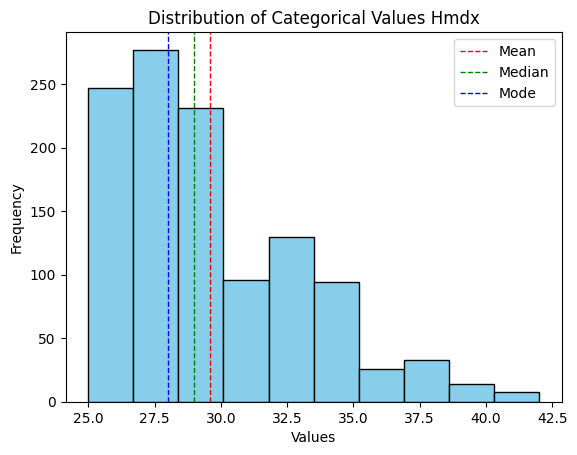

Mean Value:  -10.91904761904762 Median Value:  -9.0 Mode Value:  0   -6.0
dtype: float64


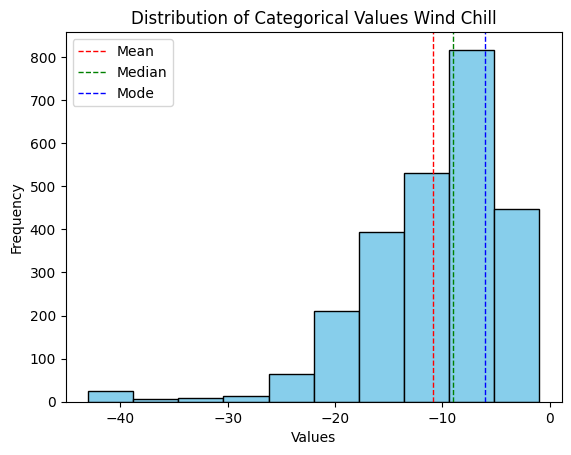

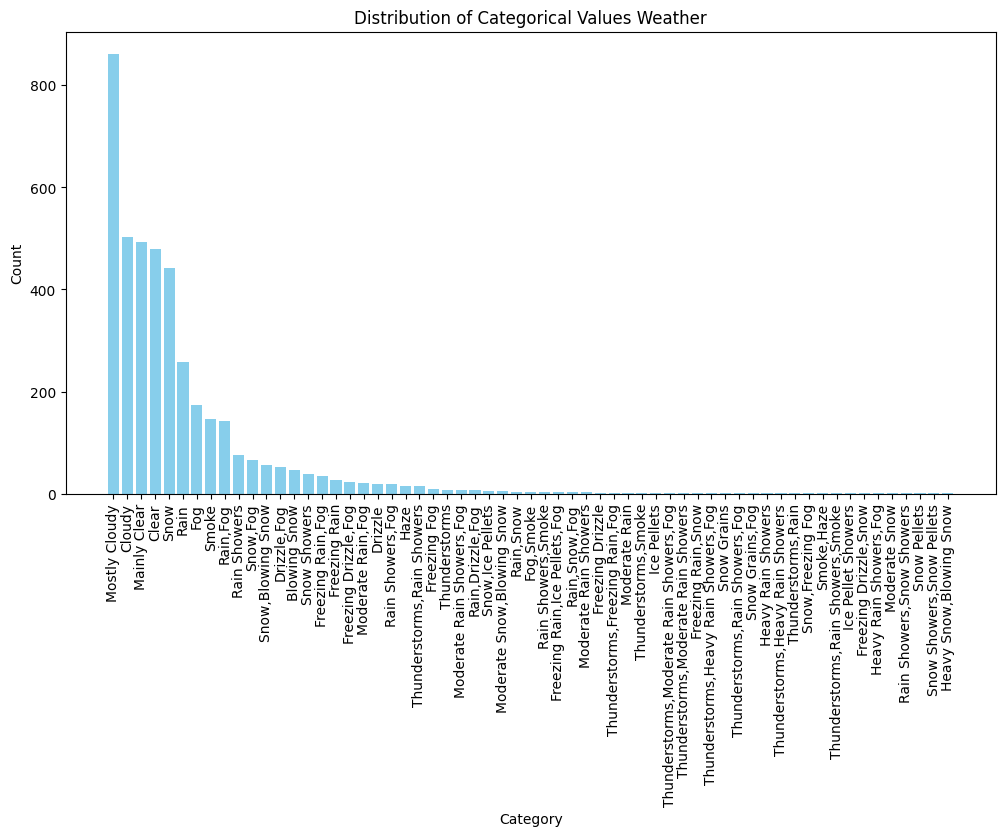

In [25]:
def plot_feature_distribution(data_df, column):
    # we observe that Hmdx, Wind Chill and Weather have the most number of missing values
    chop = data_df[column].dropna()
    
    if data_df[column].dtype in ["category","object"]:
        # for categorical columns
        category_counts = chop.value_counts()
        # print(category_counts.index.tolist())
        plt.figure(figsize=(12, 6))
        plt.bar(category_counts.index, category_counts.values, color='skyblue', width = 0.8)
        plt.xticks(rotation=90)
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.title(f'Distribution of Categorical Values {column}')
        
    elif data_df[column].dtype in ["float64","int64"]:
        # for other continous variable columns
        plt.hist(chop, bins=10, color='skyblue', edgecolor='black')
        # Calculate mean value
        print("Mean Value: ", chop.mean(), "Median Value: ", chop.median(), "Mode Value: ", chop.mode())
        # Add a vertical line at the mean value
        plt.axvline(chop.mean(), color='red', linestyle='dashed', linewidth=1)
        plt.axvline(chop.median(), color='green', linestyle='dashed', linewidth=1)
        plt.axvline(chop.mode()[0], color='blue', linestyle='dashed', linewidth=1)

        plt.legend(['Mean', 'Median', 'Mode'])

        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Categorical Values {column}')
        
    plt.show()
    
# plot distribbutions and measure of central tendencies
plot_feature_distribution(data_df, "Hmdx")
plot_feature_distribution(data_df, "Wind Chill")
plot_feature_distribution(data_df, "Weather")

## Fill missing values based on most frequent occurrence (mode as a measure of central tendancy)

In [26]:
# fill the missing values
data_df = data_df.fillna(data_df.mode().iloc[0])

## Pre-process the Weather column
The weather column has values which are concatenation of weather conditions. eg: "Rain,haze". We can split these columns into separate categorical variables for "Rain" and "Haze". 

In [27]:
# split the Weather column (as its based on concatenation of multiple weather attributes)
weather_values = set(data_df['Weather'].tolist())

weather_values = [x.split(",") for x in weather_values]
weather_values_mod = []
for weath_sub in weather_values:
    weather_values_mod.extend(weath_sub)
weather_values = set(weather_values_mod)
print("Unique weather categories: ", weather_values)
print("Num unique categories: ", len(weather_values))

Unique weather categories:  {'Heavy Rain Showers', 'Ice Pellet Showers', 'Drizzle', 'Smoke', 'Thunderstorms', 'Cloudy', 'Freezing Drizzle', 'Freezing Rain', 'Freezing Fog', 'Rain', 'Snow Pellets', 'Snow Showers', 'Blowing Snow', 'Haze', 'Clear', 'Mainly Clear', 'Moderate Snow', 'Heavy Snow', 'Snow Grains', 'Ice Pellets', 'Snow', 'Fog', 'Moderate Rain Showers', 'Moderate Rain', 'Mostly Cloudy', 'Rain Showers'}
Num unique categories:  26


In [28]:
for un_weath_category in weather_values:
    # create a category name same as the unique category
    data_df[un_weath_category]=data_df['Weather'].apply(lambda col_val: int(un_weath_category in col_val.split(",")))

In [29]:
pd.set_option('display.max_columns', None)
data_df.head(5)

,Month,Day,Time (LST),Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather,Meter Reading (KWHr),Heavy Rain Showers,Ice Pellet Showers,Drizzle,Smoke,Thunderstorms,Cloudy,Freezing Drizzle,Freezing Rain,Freezing Fog,Rain,Snow Pellets,Snow Showers,Blowing Snow,Haze,Clear,Mainly Clear,Moderate Snow,Heavy Snow,Snow Grains,Ice Pellets,Snow,Fog,Moderate Rain Showers,Moderate Rain,Mostly Cloudy,Rain Showers
0,1,1,hour_0,3.0,3.0,100.0,28.0,11.0,0.4,99.11,28.0,-6.0,Fog,350.991,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,hour_1,3.0,3.0,100.0,26.0,10.0,0.4,99.16,28.0,-6.0,Fog,352.707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,1,hour_2,3.0,3.0,100.0,30.0,21.0,6.4,99.22,28.0,-6.0,Fog,349.177,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,1,hour_3,2.6,2.6,100.0,28.0,24.0,8.1,99.27,28.0,-6.0,Fog,349.923,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,1,hour_4,2.4,2.4,100.0,28.0,23.0,11.3,99.33,28.0,-6.0,Cloudy,351.596,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# Save intermediate dataframe for Exploratory Data Analysis
data_df.to_csv("Data/eda_newData.csv", index = False)

# Exploratory Data Analysis

In [2]:
eda_df = pd.read_csv("Data/eda_newData.csv")

## First, we try to see if there is some correlation between the "temperature" and "meter reading" based on whether it snows or not. For this we plot a Kernel Density (KDE) plot

We observe the following: Firstly all the meter readings from 200 to 600KWHr corresponds to temperatures in the range of -20 to +30 degree Celcius. A higher density of samples have an electricity consumtion of 500kWhr corresponding to 0 degrees when it snows, in addition to 300kWhr or 400KWHr when it does not snow. The fluctuations could be due to other variables/features that also influence the readings.

<AxesSubplot:xlabel='Meter Reading (KWHr)', ylabel='Temp (°C)'>

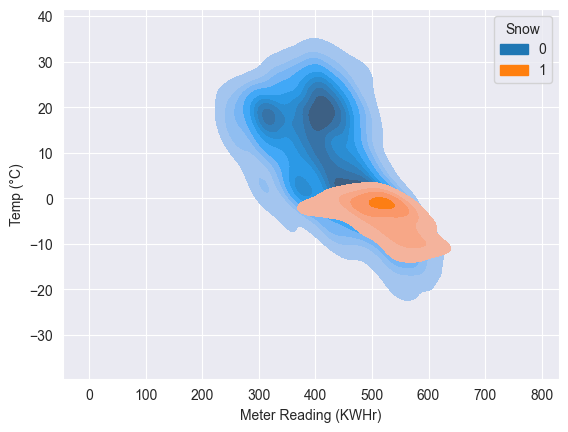

In [66]:
# bivariate analysis with hue
sns.set_style('darkgrid')
sns.kdeplot(data=eda_df, x="Meter Reading (KWHr)", y="Temp (°C)", hue="Snow", fill=True)

# Next, we observe the relationship between the "windchill" and the target meter reading

ToDO: Raymond add observations

Text(0.5, 1.0, 'Boxplots for Visibility and Meter Reading')

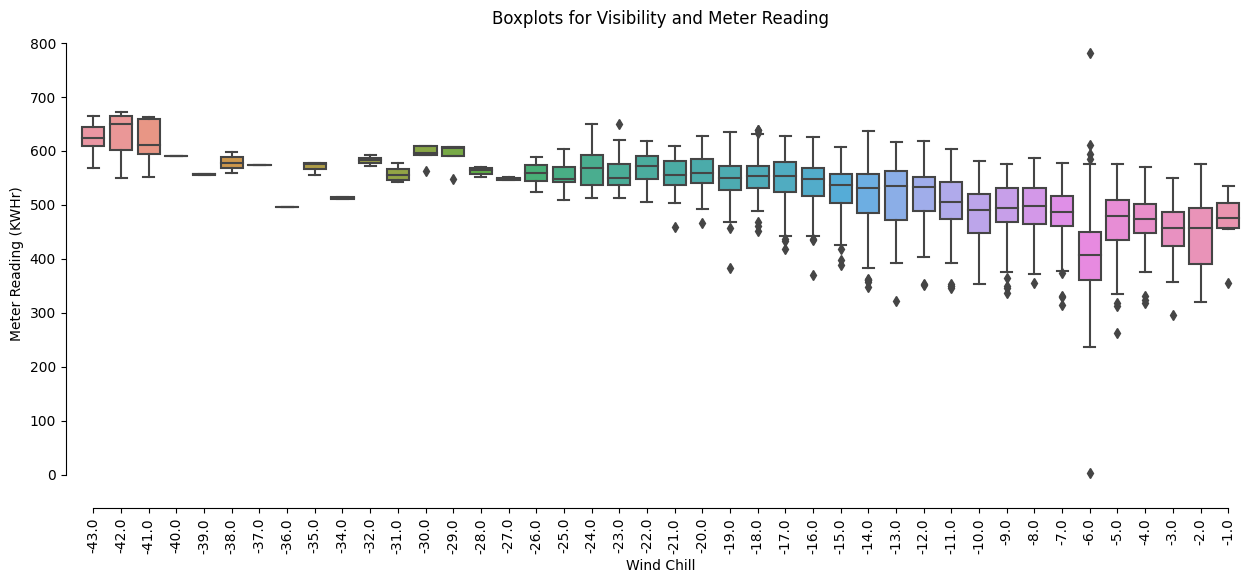

In [15]:
import copy
plt.figure(figsize=(15, 6))
boxplot_data=eda_df
boxplot_data=boxplot_data.sort_values(by='Wind Chill')
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Wind Chill", y="Meter Reading (KWHr)",
            data=boxplot_data)

sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.title("Boxplots for Visibility and Meter Reading")

## We try to see the relation between "Temperature", "Meter reading" and "Month" using a bivariate plot with marginal distributions.

We can see that except of few outliers in the month of December, most of the data clusters around a meter reading 300-600 KWhr. The highest meter readings are observed around at the end of the year in general and beginning of the year.

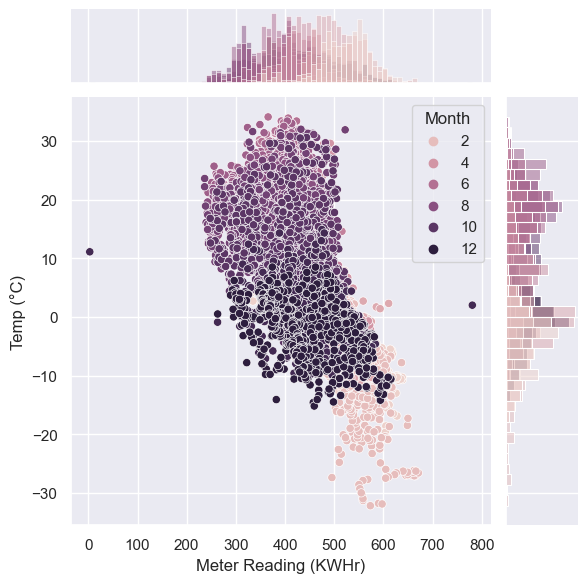

In [71]:
sns.set_style('darkgrid')
g = sns.JointGrid(data=eda_df, x="Meter Reading (KWHr)", y="Temp (°C)", hue="Month")
g.plot(sns.scatterplot, sns.histplot)

# We plot a heat map of variable correlations to observe possible relations between different features in the dataset

We can come up with the following observations:
1. Most of the heat-map shows zero correlations (light purple colour).
2. Meter Reading has a negative correlation with temperature (showing as temperature increases, meter reading decreases, which could hint towards the fact that heating in cold climate consumes more energy than AC usage in summer. 
3. Visibility has negative correlation with fog and mist features, which is as expected.
4. ....

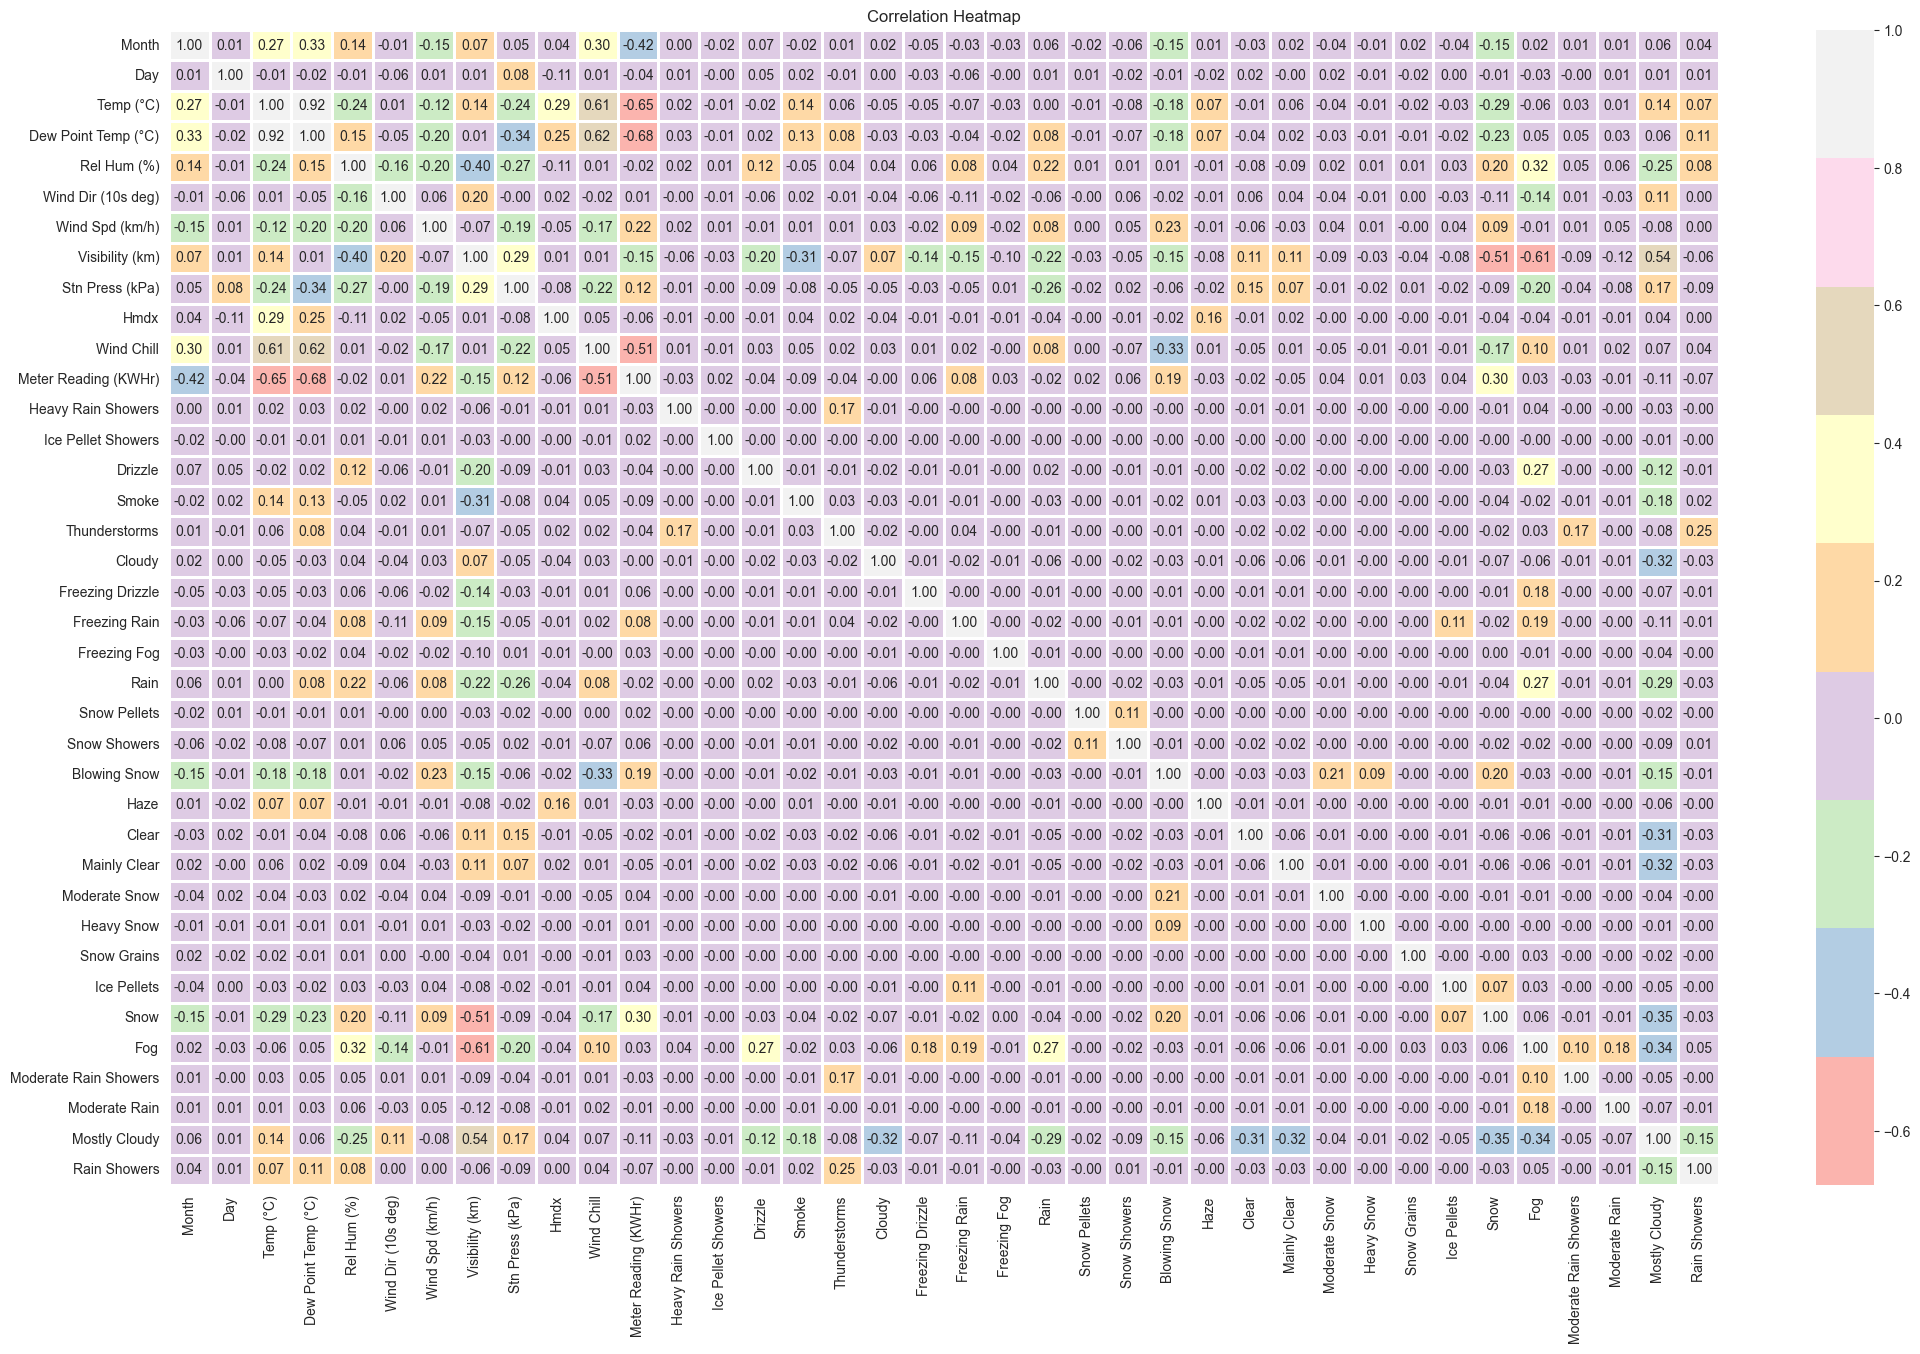

In [54]:
# multivariate correlation between all variables
plt.figure(figsize=(25, 15))
sns.heatmap(eda_df.corr(), annot=True, fmt='.2f', cmap='Pastel1', linewidths=2)
plt.title('Correlation Heatmap')
plt.show()

# we also plot bivariate plots with major features and the target variable
df_subset = df[["Temp (°C)","Dew Point Temp (°C)","Rel Hum (%)","Wind Dir (10s deg)","Wind Spd (km/h)","Visibility (km)","Stn Press (kPa)","Hmdx","Wind Chill","Meter Reading (KWHr)"]]
sns.pairplot(df_subset)

## Next we try to see the relationship between month and meter readings, and hour of the day and meter reading.

ToDO: Add explanations here of observations... Raymond

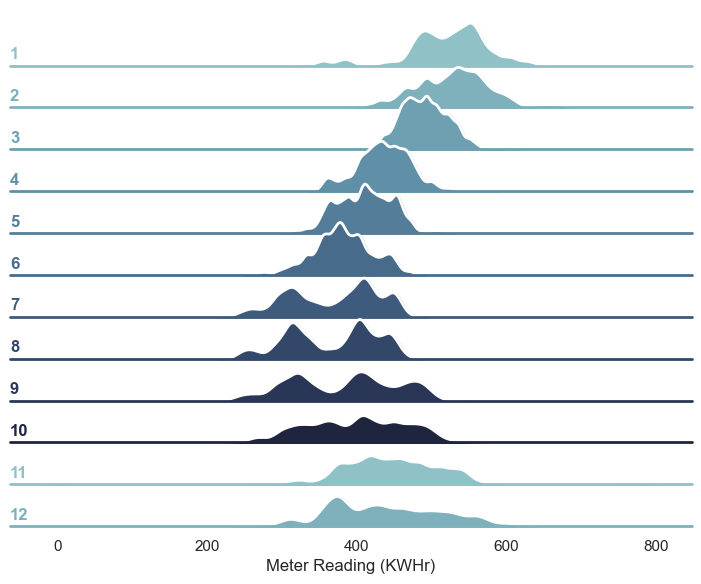

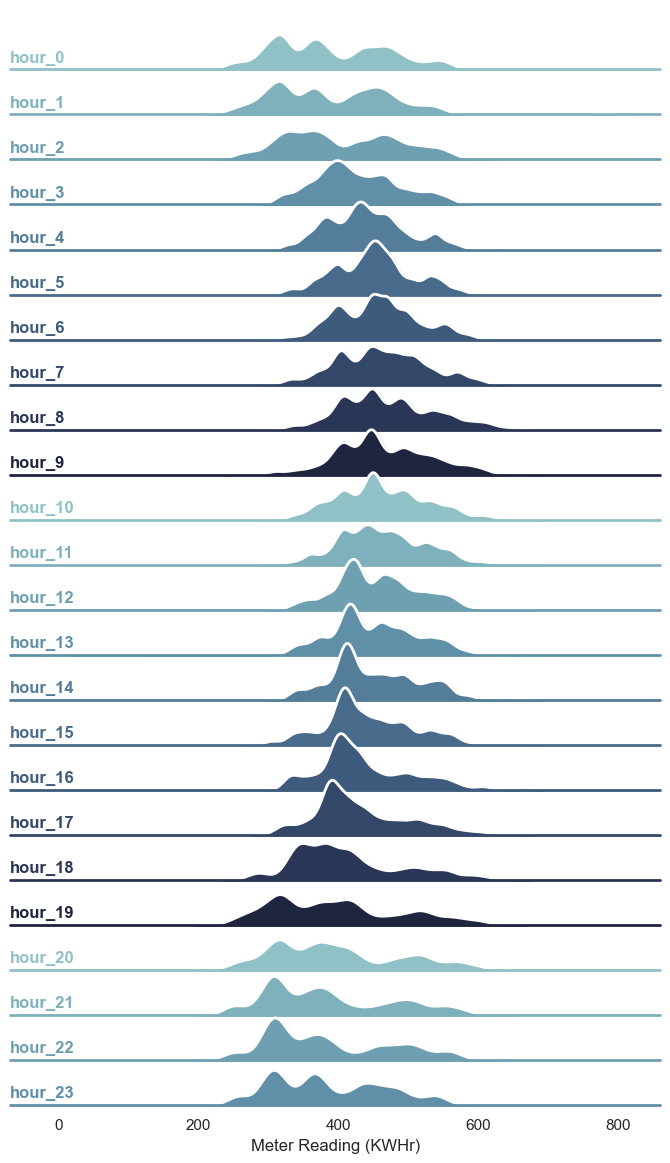

In [69]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

features_of_interest = ["Month", "Time (LST)"]
for feat_of_int in features_of_interest:
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(eda_df, row=feat_of_int, hue=feat_of_int, aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Meter Reading (KWHr)",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "Meter Reading (KWHr)", clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "Meter Reading (KWHr)")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

# Feature Processing for Model Training

1. Convert categorical variables to one-hot-encoding.
2. Scale/Normalize the resultant features so as to feed a model.

In [31]:
# now we can convert categorical value to their one-hot encoding
# first we get rid of weather column as its converted
data_df.drop(columns=['Weather'], inplace=True)

## Convert categorical variables to their one-hot encoding representations

In [32]:
data_df_exp = pd.get_dummies(data_df, dtype='int64')

In [33]:
scaler = MinMaxScaler()
# now we can perform min-max normalization on all columns before feature preparation
data_df = data_df_exp.drop(columns=['Meter Reading (KWHr)'])
data_df_norm = pd.DataFrame(scaler.fit_transform(data_df), columns=data_df.columns)
data_df_norm = pd.concat([data_df_norm, data_df_exp['Meter Reading (KWHr)']], axis=1)

In [34]:
data_df_norm.head(2)

,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Heavy Rain Showers,Ice Pellet Showers,Drizzle,Smoke,Thunderstorms,Cloudy,Freezing Drizzle,Freezing Rain,Freezing Fog,Rain,Snow Pellets,Snow Showers,Blowing Snow,Haze,Clear,Mainly Clear,Moderate Snow,Heavy Snow,Snow Grains,Ice Pellets,Snow,Fog,Moderate Rain Showers,Moderate Rain,Mostly Cloudy,Rain Showers,Time (LST)_hour_0,Time (LST)_hour_1,Time (LST)_hour_2,Time (LST)_hour_3,Time (LST)_hour_4,Time (LST)_hour_5,Time (LST)_hour_6,Time (LST)_hour_7,Time (LST)_hour_8,Time (LST)_hour_9,Time (LST)_hour_10,Time (LST)_hour_11,Time (LST)_hour_12,Time (LST)_hour_13,Time (LST)_hour_14,Time (LST)_hour_15,Time (LST)_hour_16,Time (LST)_hour_17,Time (LST)_hour_18,Time (LST)_hour_19,Time (LST)_hour_20,Time (LST)_hour_21,Time (LST)_hour_22,Time (LST)_hour_23,Meter Reading (KWHr)
0,0.0,0.0,0.53092,0.652755,1.0,0.777778,0.211538,0.016598,0.408935,0.176471,0.880952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.991
1,0.0,0.0,0.53092,0.652755,1.0,0.722222,0.192308,0.016598,0.417526,0.176471,0.880952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.707


In [35]:
# Save final preprocessed file
data_df_norm.to_csv("Data/preprocessed_newData.csv", index = False)

# Feature Selection for Regression using Statistical Analysis

In this part we select the most important features for regression. We employ a statistical measure called "Mutual Information" for measuring the correlation of the individual variables to the target variable and decide its feature importance.

In [36]:
df = pd.read_csv("Data/preprocessed_newData.csv")

In [37]:
all_cols = df.columns
target_col = "Meter Reading (KWHr)"
feature_col = all_cols.drop(target_col).tolist()
target_col = [target_col]
# we use mutual info regression to determine feature importance (as F-statistic) can only capture linear dependencies
# between feature and the target variable
features_df = df[feature_col]
target_df = df[target_col]

mi_scores = mutual_info_regression(features_df, target_df)

# create a mapping from column name to value
feature_imp_map = {feature:mi_scores[i] for i, feature in enumerate(features_df.columns)}
# sort the values
sorted_feature_imp = sorted(feature_imp_map.items(), key=lambda x: -x[1])

Text(0.5, 1.0, 'Mutual Information')

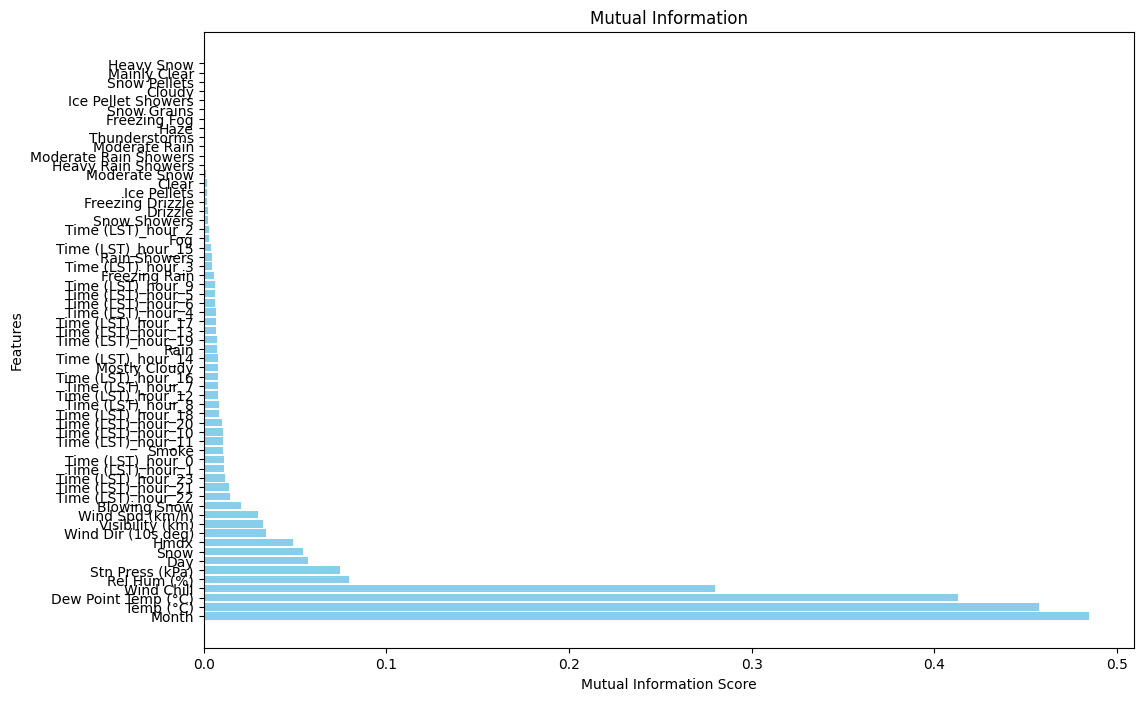

In [38]:
# Extracting labels and values
labels, values = zip(*sorted_feature_imp)

# Plotting the bar graph of feature importances.
plt.figure(figsize=(12, 8))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Mutual Information')

## We can note the feature importances of the data from the above graph (its skewed to the right)
1.  The categorical features for hour and type of weather have very less importance according to mutual information with the target variable
2.  For the purpose of this experiment, we select the top-k features where k is determined based on the first index where feature impotance becomes 0 (features arranged in decreasing order of magnitude of the feature importance)

In [47]:
# find features with zero importance 
filtered_features = [entry[0] for entry in sorted_feature_imp if entry[1]!=0]
print("Filtered Final Features: ", filtered_features, "\n\nTotal Features: ", len(filtered_features))

Filtered Final Features:  ['Month', 'Temp (°C)', 'Dew Point Temp (°C)', 'Wind Chill', 'Rel Hum (%)', 'Stn Press (kPa)', 'Day', 'Snow', 'Hmdx', 'Wind Dir (10s deg)', 'Visibility (km)', 'Wind Spd (km/h)', 'Blowing Snow', 'Time (LST)_hour_22', 'Time (LST)_hour_21', 'Time (LST)_hour_23', 'Time (LST)_hour_1', 'Time (LST)_hour_0', 'Smoke', 'Time (LST)_hour_11', 'Time (LST)_hour_10', 'Time (LST)_hour_20', 'Time (LST)_hour_18', 'Time (LST)_hour_8', 'Time (LST)_hour_12', 'Time (LST)_hour_7', 'Time (LST)_hour_16', 'Mostly Cloudy', 'Time (LST)_hour_14', 'Rain', 'Time (LST)_hour_19', 'Time (LST)_hour_13', 'Time (LST)_hour_17', 'Time (LST)_hour_4', 'Time (LST)_hour_6', 'Time (LST)_hour_5', 'Time (LST)_hour_9', 'Freezing Rain', 'Time (LST)_hour_3', 'Rain Showers', 'Time (LST)_hour_15', 'Fog', 'Time (LST)_hour_2', 'Snow Showers', 'Drizzle', 'Freezing Drizzle', 'Ice Pellets', 'Clear', 'Moderate Snow', 'Heavy Rain Showers', 'Moderate Rain Showers', 'Moderate Rain', 'Thunderstorms', 'Haze', 'Freezing Fo

In [40]:
final_features_df = features_df[filtered_features]
final_target_df = target_df

# Train and Evaluate Models

## Random Forests & Multi-Layer Perceptrons

We use 5-fold cross-validation for all the experiments. 5 folds, leaves 4 folds for training and 1 fold for testing in each cycle. Totally there will be 5 cycles and we average the results on the test set for obtaining the final model performance. By construction each fold has 80% training data (4 folds x 20) and 20% testing data (1 fold x 20). For the purpose of comparing model performances we use the MSE (Mean Squared Error) metric. The MSE metric can only be compared w.r.t to a baseline model. Hence, we use a random predictor regressor as a baseline to determine the improvement in MSE we achieved by training the Random Forest model and MLP model.

In [43]:
# we can now evaluate the models using k-fold cross-val
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)


scores_folds_rf, scores_folds_mlp, scores_folds_baseline = [], [], []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(final_features_df)), total=num_folds):
    # form the splits
    train_x, train_y = final_features_df.iloc[train_index], final_target_df.iloc[train_index]
    test_x, test_y = final_features_df.iloc[test_index], final_target_df.iloc[test_index]
    
    # now train the model
    
    # create a baseline
    # Modelb: baseline
    baseline_model_pred = np.random.uniform(low=test_y.min(), high=test_y.max(), size=len(test_y))
    mse_score = mean_squared_error(test_y,baseline_model_pred)
    scores_folds_baseline.append(mse_score)
    
    # Model1: Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
    rf_model.fit(train_x, train_y)
    rf_model_pred = rf_model.predict(test_x)
    mse_score = mean_squared_error(test_y, rf_model_pred)
    scores_folds_rf.append(mse_score)
    
    # Model2: MultiLayer Perceptron Regressor
    # alpha is L2 
    mlp_model = MLPRegressor(hidden_layer_sizes=(100,50,100), activation='relu', solver='adam', random_state=42, alpha=0.01)
    mlp_model.fit(train_x, train_y)
    mlp_model_pred = mlp_model.predict(test_x)
    mse_score = mean_squared_error(test_y, mlp_model_pred)
    scores_folds_mlp.append(mse_score)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:38<00:00, 43.73s/it]


In [44]:
# average score across all folds for all the models under consideration
avg_rf_score = sum(scores_folds_rf)/len(scores_folds_rf)
avg_mlp_score = sum(scores_folds_mlp)/len(scores_folds_mlp)
avg_baseline_score = sum(scores_folds_baseline)/len(scores_folds_baseline)
print(f"Average MSE of Random Forest: {avg_rf_score}")
print(f"Average MSE of MLP Model: {avg_mlp_score}")
print(f"Average MSE of baseline Model (Random Predictor): {avg_baseline_score}")

Average MSE of Random Forest: 926.6409687904448
Average MSE of MLP Model: 1326.6319833967877
Average MSE of baseline Model (Random Predictor): 30502.385740401398


# Model Performance Qualitative Analysis

In this section we perform a series of model performance vizualizations. The model outputs are compared to that of the real values from the ground truth in addition to comparison of model output w.r.t to each other (Random Forest vs Multi-layer perceptron)

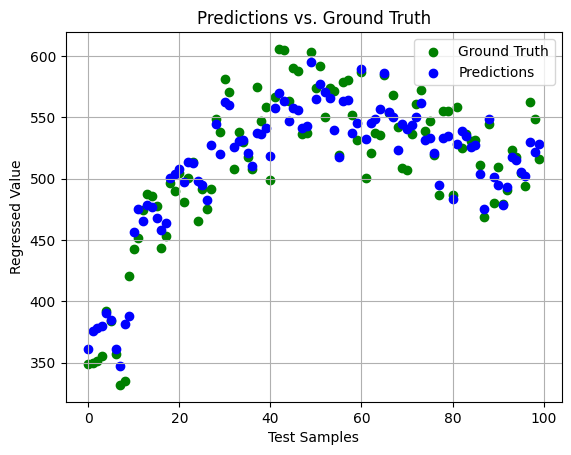

In [45]:
# scatter plot of the first_k data samples of the last fold in k-fold (arbitrarily chosen to see if model learns the patterns)
first_k = 100
sample_pred = rf_model.predict(test_x)[:first_k]
sample_gt = test_y.iloc[:, 0].tolist()[:first_k]

# Create scatter plots for predictions and ground truth
plt.scatter(range(len(sample_gt)), sample_gt, color='green', label='Ground Truth')
plt.scatter(range(len(sample_pred)), sample_pred, color='blue', label='Predictions')

plt.gca().set_aspect('auto', adjustable='datalim')
plt.xlabel('Test Samples')
plt.ylabel('Regressed Value')
plt.title('Predictions vs. Ground Truth')
plt.legend()
plt.grid(True)
plt.show()